Uses an autoencoder to approximate the habituation/dishabituation process
An autoencoder is afixed ontop of the pre-trained model 
LiMA stim are run through it

Author: VAYZENB

In [1]:
import sys
import os, argparse
from collections import OrderedDict
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import cornet
from torchvision import datasets
import torchvision.models as models
import numpy as np
from LoadFrames import LoadFrames
from statistics import mean
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
exp = ['Exp1', 'Exp2']

skel = [['23','31', '26'],['31_0', '31_50']]
SF = ['Skel', 'Bulge']
modelType = ['SayCam','CorNet_Z', 'CorNet_S','AlexNet_SN', 'ResNet_SN', 'AlexNet_IN', 'ResNet_IN']

exp = ['Exp1']
skel=[['23']]
SF = ['Skel']
modelType = ['ResNet_IN']

#Transformations for ImageNet
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])
# specify loss function
criterion = nn.MSELoss()
criterion.cuda()

epochs = 30

#Gets feats for CorNet models
def _store_feats(layer, inp, output):
    """An ugly but effective way of accessing intermediate model features
    """   
    output = output.cpu().detach().numpy()
    #_model_feats.append(np.reshape(output, (len(output), -1)))



In [3]:
def load_model(modelType_):
    #select model to run
    if modelType_ == 'AlexNet_IN':
        model = torchvision.models.alexnet(pretrained=True)
        new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
        model.classifier = new_classifier #replace model classifier with stripped version
        layer = "fc7"
        actNum = 4096
        
    elif modelType_ == 'ResNet_IN':
        model = torchvision.models.resnet50(pretrained=True)
        model = nn.Sequential(*list(model.children())[:-1])
        layer = "avgpool"
        actNum = 2048
                
    elif modelType_ == 'AlexNet_SN':
        model = torchvision.models.alexnet(pretrained=False)
        checkpoint = torch.load('Weights/ShapeNet_AlexNet_Weights.pth.tar')
        model.load_state_dict(checkpoint)
        new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
        model.classifier = new_classifier #replace model classifier with stripped version
        layer = "fc7"
        actNum = 4096
        
    elif modelType_ == 'ResNet_SN':
        model = torchvision.models.resnet50(pretrained=False)
        checkpoint = torch.load('Weights/ShapeNet_ResNet50_Weights.pth.tar')
        model.load_state_dict(checkpoint)
        model = nn.Sequential(*list(model.children())[:-1])
        
        layer = "avgpool"
        actNum = 2048
    
    elif modelType_ == 'CorNet_Z':
        model = getattr(cornet, 'cornet_z')
        model = model(pretrained=False, map_location='gpu')
        
        layer = "avgpool"
        actNum = 512
    
        try:
            m = model.module
        except:
            m = model
        model_layer = getattr(getattr(m, 'decoder'), layer)
        model_layer.register_forward_hook(_store_feats)

    elif modelType[mm] == 'CorNet_S':
        model = getattr(cornet, 'cornet_s')
        model = model(pretrained=False, map_location='gpu')
        
        layer = "avgpool"
        actNum = 512        

        try:
            m = model.module
        except:
            m = model
        
        model_layer = getattr(getattr(m, 'decoder'), layer)
        model_layer.register_forward_hook(_store_feats)

    elif modelType[mm] == 'SayCam':
        model = torchvision.models.resnext50_32x4d(pretrained=False)
        model = torch.nn.DataParallel(model)
        #model.fc = torch.nn.Linear(in_features=2048, out_features=n_out, bias=True)
        checkpoint = torch.load('Weights/SayCam_ResNext_Weights.pth.tar')
        model.load_state_dict(checkpoint)
        
        actNum = 512

        model = nn.Sequential(*list(model.children())[:-1])
        
    return model, actNum

In [4]:
hab_min = 4

for mm in range(0, len(modelType)):
    encoder, in_feat = load_model(modelType[mm])
    #Create decoder
    decoder = nn.Sequential(nn.ReLU(), nn.ConvTranspose2d(in_feat, 3, 224))
    
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    encoder.eval()
    decoder.eval()
    decoder.train()
    
    #set up optimzer
    optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01)
    
    for ee in range(0,len(exp)):
        for sk in range(0,len(skel[ee])):
            for sf in SF:
                hab_dataset = LoadFrames(f'Frames/Figure_{skel[ee][sk]}_{sf}', transform=transform)
                trainloader = torch.utils.data.DataLoader(hab_dataset, batch_size=10, shuffle=False, num_workers = 4, pin_memory=True)

                early_hab = 0.0
                late_hab = []
                
                for ep in range(0,epochs):
                    train_loss = 0.0 
                    n = 0
                    for frames in trainloader:
                        frames = frames.cuda()
                        encode_out = encoder(frames) #Get encoder features
                        
                        optimizer.zero_grad() #zero out gradients from previous epoch
                        
                        decode_out = decoder(encode_out) #Run features through decoder
                        print(frames.shape, encode_out.shape, decode_out.shape)

                        loss = criterion(decode_out, frames) #Calculate loss

                        # backward pass: compute gradient of the loss with respect to model parameters
                        loss.backward()
                        # perform a single optimization step (parameter update)
                        optimizer.step()

                        train_loss += (loss.item()*frames.size(0))
                        n = n +1
                        #print(train_loss, loss.item()*frames.size(0), n)

                    total_loss = train_loss/n

                    if ep < hab_min:
                        early_hab += total_loss #track loss for the first 4 trials
                        print(ep, total_loss)
                    elif ep >= hab_min:
                        hab_crit = early_hab / hab_min #Determine habituation criterion
                        late_hab.append(total_loss) #add current loss to habituation
                        curr_hab = mean(late_hab[(len(late_hab)-4):len(late_hab)]) #calcualte mean of last 4 hab trials

                        print(ep, total_loss, hab_crit, curr_hab)
                        if curr_hab < (hab_crit/2): #test if habituated
                            break

                print('Saving model', modelType[mm], f'Figure_{skel[ee][sk]}_{sf}')                
                torch.save(decoder.state_dict(), f'Weights/decoder/{modelType[mm]}_Figure_{skel[ee][sk]}_{sf}.pt')


            
    

0 75.17527792194197
1 344.70008185602006
2 788.4761943048046
3 357.1012068871529
4 264.32229411217475 391.36319024247985 264.32229411217475
5 165.02204814264852 391.36319024247985 214.67217112741162
6 268.7336432395443 391.36319024247985 268.7336432395443
7 235.11549122102798 391.36319024247985 233.29836917884887
8 255.55783041061895 391.36319024247985 231.10725325345993
9 788.0248703495149 391.36319024247985 386.8579588051765
10 1934.010376222672 391.36319024247985 803.1771420509584
11 6899.806228637695 391.36319024247985 2469.3498264051254
12 26294.57388748661 391.36319024247985 8979.103840674123
13 39630.02854181105 391.36319024247985 18689.604758539506
14 18410.892757292717 391.36319024247985 22808.82535380702
15 4843.987352924963 391.36319024247985 22294.870634878836
16 1851.791097579464 391.36319024247985 16184.17493740205
17 1176.8501513081212 391.36319024247985 6570.880339776316
18 810.8489105470719 391.36319024247985 2170.869378089905
19 557.0572235968805 391.36319024247985 10

In [85]:
decoder.eval()

out=encoder(IM)
out = decoder(out)

out = out.squeeze(0)
print(out.shape)

In [86]:
loss = criterion(out, IM)
print(loss.item()*IM.size(0))

6.938354969024658


From here on is image preview

In [87]:
out = out.squeeze(0)
print(out.shape)
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

output = inv_normalize(out)
print(output.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


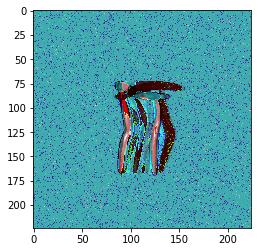

In [88]:
output = output.cpu().detach()
plt.imshow(output.permute(1, 2, 0))


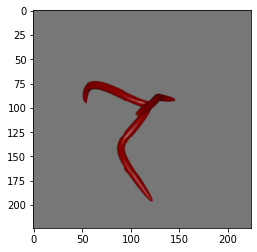

In [89]:
IM = IM.squeeze(0)
IM = inv_normalize(IM)
IM = IM.cpu().detach()
plt.imshow(IM.permute(1, 2, 0))